In [1]:
import pandas as pd
import matplotlib
from sklearn import preprocessing
from sklearn import model_selection
%matplotlib inline

In [2]:
df = pd.read_csv('/home/rich/src/data/nfl_plays.csv')
df.shape

/home/rich/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(449371, 255)

In [3]:
nedf = df[(df.posteam=='NE') & (df.down.isin([1.0, 2.0, 3.0, 4.0])) & ((df.play_type=='run') | (df.play_type == 'pass'))]
nedf.groupby('play_type').count()[['play_id']]
del df
nedf = nedf[['game_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'score_differential', 'play_type', 'pass_length', 'pass_location', 'run_location']]
nedf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location
2390,3592.0,49.0,1.0,10,0,0.0,pass,short,right,NaN
2391,3587.0,49.0,2.0,10,0,0.0,run,NaN,NaN,right
2392,3543.0,46.0,3.0,7,1,0.0,pass,short,middle,NaN
2393,3519.0,40.0,4.0,1,0,0.0,run,NaN,NaN,left
2399,3434.0,83.0,1.0,10,1,0.0,run,NaN,NaN,middle


In [4]:
import numpy as np
def get_full_play_type(play):
    play_type, pass_length, pass_location, run_location = play
    if(play_type == 'run'):
        return play_type+'_'+run_location
    else:
        return play_type+'_'+pass_location
nedf = nedf.replace(np.nan, 'unknown', regex=True)    
nedf['full_play_type'] = nedf[['play_type', 'pass_length', 'pass_location', 'run_location']].apply(get_full_play_type, axis=1)    
nedf = nedf[(nedf.full_play_type.isin(['pass_left', 'pass_middle','pass_right','run_left', 'run_middle', 'run_right']))]
nedf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,full_play_type
2390,3592.0,49.0,1.0,10,0,0.0,pass,short,right,unknown,pass_right
2391,3587.0,49.0,2.0,10,0,0.0,run,unknown,unknown,right,run_right
2392,3543.0,46.0,3.0,7,1,0.0,pass,short,middle,unknown,pass_middle
2393,3519.0,40.0,4.0,1,0,0.0,run,unknown,unknown,left,run_left
2399,3434.0,83.0,1.0,10,1,0.0,run,unknown,unknown,middle,run_middle


In [5]:
nedf.groupby(['full_play_type']).count()[['play_type']]

,play_type
full_play_type,
pass_left,2360
pass_middle,1578
pass_right,1927
run_left,1715
run_middle,1223
run_right,1396


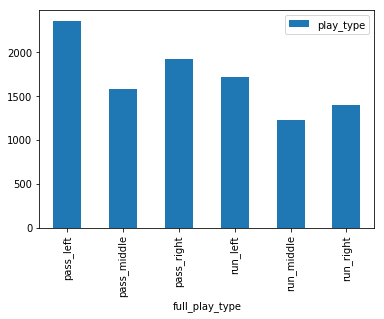

In [6]:
nedf.groupby(['full_play_type']).count()[['play_type']].plot(kind='bar')


In [7]:
nedf.groupby(['full_play_type']).count()[['play_type']].apply(lambda x:100 * x / float(x.sum()))

,play_type
full_play_type,
pass_left,23.139523
pass_middle,15.472105
pass_right,18.894009
run_left,16.815374
run_middle,11.991372
run_right,13.687616


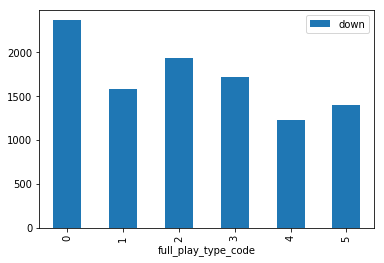

In [8]:
le = preprocessing.LabelEncoder()
le.fit(nedf.full_play_type)
nedf['full_play_type_code'] = le.transform(nedf['full_play_type'])
nedf.groupby(['full_play_type_code']).count()[['down']].plot(kind='bar')

In [9]:
def bucketize(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i

def bucketize_df(df):
    df['ydstogo'] = [bucketize(x, 4, 5) for x in df['ydstogo']]
    return df

nedf = bucketize_df(nedf)

In [11]:
nedf = pd.concat([nedf, pd.get_dummies(nedf['down'], prefix='down')], axis=1)
nedf = pd.concat([nedf, pd.get_dummies(nedf['ydstogo'], prefix='ydstogo')], axis=1)

In [12]:
nedf.describe()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,full_play_type_code,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
count,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000
mean,1763.715168,48.930385,1.753603,1.533190,0.483479,4.026179,2.201098,0.461908,0.335915,0.188842,0.013335,0.186391,0.187764,0.561526,0.034905,0.029415
std,1016.843757,25.204799,0.802147,0.931699,0.499751,10.745336,1.708754,0.498571,0.472333,0.391402,0.114709,0.389441,0.390542,0.496224,0.183549,0.168974
min,3.000000,1.000000,1.000000,0.000000,0.000000,-33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,900.000000,29.000000,1.000000,1.000000,0.000000,-3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1800.000000,51.000000,2.000000,2.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2625.000000,70.000000,2.000000,2.000000,1.000000,10.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3600.000000,99.000000,4.000000,4.000000,1.000000,59.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
nedf['game_seconds_remaining']/=3600

In [16]:
nedf['yardline_100']/=100
nedf['score_differential']=(nedf['score_differential']+50)/100

In [17]:
nedf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,...,full_play_type_code,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
2390,0.997778,0.49,1.0,2,0,0.5,pass,short,right,unknown,...,2,1,0,0,0,0,0,1,0,0
2391,0.996389,0.49,2.0,2,0,0.5,run,unknown,unknown,right,...,5,0,1,0,0,0,0,1,0,0
2392,0.984167,0.46,3.0,1,1,0.5,pass,short,middle,unknown,...,1,0,0,1,0,0,1,0,0,0
2393,0.977500,0.40,4.0,0,0,0.5,run,unknown,unknown,left,...,3,0,0,0,1,1,0,0,0,0
2399,0.953889,0.83,1.0,2,1,0.5,run,unknown,unknown,middle,...,4,1,0,0,0,0,0,1,0,0


In [18]:
X=nedf[['yardline_100', 'shotgun', 'score_differential', 'game_seconds_remaining', 'down_1.0', 'down_2.0', 'down_3.0', 'down_4.0','ydstogo_0','ydstogo_1','ydstogo_2','ydstogo_3','ydstogo_4']]

In [19]:
X.head()

,yardline_100,shotgun,score_differential,game_seconds_remaining,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
2390,0.49,0,0.5,0.997778,1,0,0,0,0,0,1,0,0
2391,0.49,0,0.5,0.996389,0,1,0,0,0,0,1,0,0
2392,0.46,1,0.5,0.984167,0,0,1,0,0,1,0,0,0
2393,0.40,0,0.5,0.977500,0,0,0,1,1,0,0,0,0
2399,0.83,1,0.5,0.953889,1,0,0,0,0,0,1,0,0


In [20]:
Y=nedf['full_play_type_code']

In [21]:
Y.head()

2390    2
2391    5
2392    1
2393    3
2399    4
Name: full_play_type_code, dtype: int64

In [22]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, random_state = 0)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:
from sklearn.model_selection import cross_val_score

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "GBC"]

classifiers = [
    KNeighborsClassifier(12),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=64),
    RandomForestClassifier(max_depth=8, n_estimators=64),
    MLPClassifier(alpha=1,hidden_layer_sizes=(64),
                   activation='tanh',
                   solver='lbfgs',
                   max_iter=200),
    AdaBoostClassifier(),
    GaussianNB(),
    GradientBoostingClassifier()
]
for name, clf in zip(names, classifiers):
    clf.fit(train_x, train_y)
    #score = cross_val_score(clf, test_x, test_y, scoring='f1_weighted',cv=5)  
    
    score = clf.score(test_x, test_y)
    print('{}:{}'.format(name, score))    

In [24]:
#the_clf = DecisionTreeClassifier(max_depth=3)
#the_clf = MLPClassifier(alpha=1,hidden_layer_sizes=(50),
#                   activation='tanh',
#                   solver='lbfgs',
#                   max_iter=250)

#the_clf=AdaBoostClassifier()
#the_clf = DecisionTreeClassifier(max_depth=12)
the_clf=RandomForestClassifier(max_depth=8, n_estimators=64)
the_clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
from sklearn.metrics import accuracy_score
pred = the_clf.predict(test_x)
acc =accuracy_score(test_y, pred)

In [26]:
print(acc)

0.31176470588235294


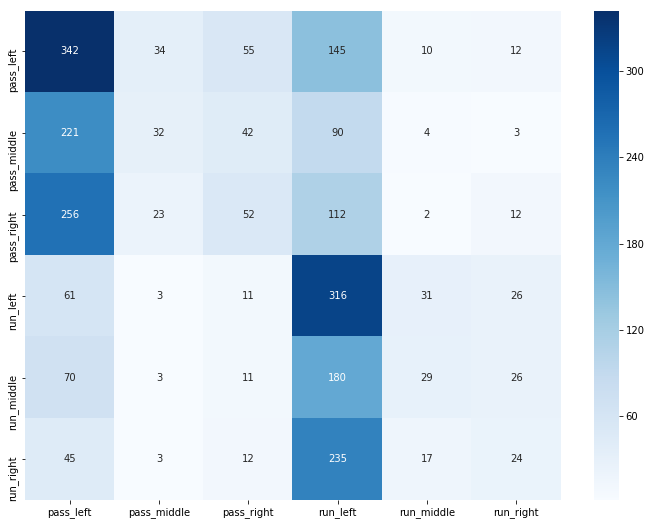

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, pred)

df_cm = pd.DataFrame(cm, index = [i for i in list(le.classes_)],
                  columns = [i for i in list(le.classes_)])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')



In [28]:
#the_clf = DecisionTreeClassifier(max_depth=3)
#the_clf = MLPClassifier(alpha=1,hidden_layer_sizes=(50),
#                   activation='tanh',
#                   solver='lbfgs',
#                   max_iter=250)

the_clf=AdaBoostClassifier()
#the_clf = DecisionTreeClassifier(max_depth=12)
#the_clf=RandomForestClassifier(max_depth=12, n_estimators=30)
the_clf.fit(train_x, train_y)

from sklearn.metrics import accuracy_score
pred = the_clf.predict(test_x)
acc =accuracy_score(test_y, pred)

print(acc)

0.29411764705882354


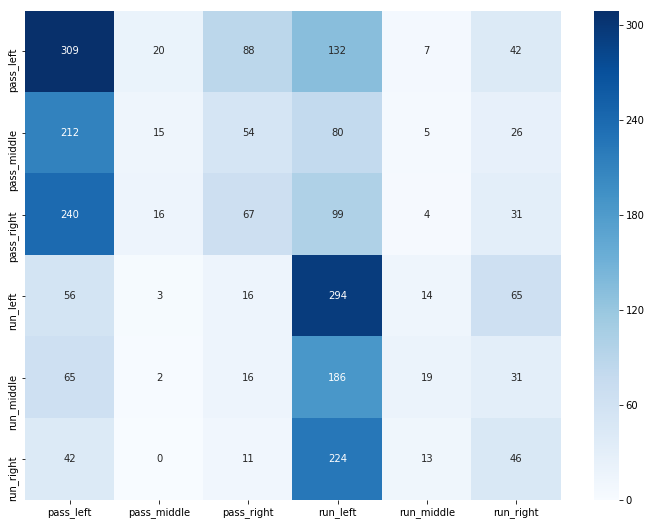

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, pred)

df_cm = pd.DataFrame(cm, index = [i for i in list(le.classes_)],
                  columns = [i for i in list(le.classes_)])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')



In [30]:
 #GradientBoostingClassifier()
    
the_clf= GradientBoostingClassifier()
the_clf.fit(train_x, train_y)

from sklearn.metrics import accuracy_score
pred = the_clf.predict(test_x)
acc =accuracy_score(test_y, pred)

print(acc)

0.2937254901960784


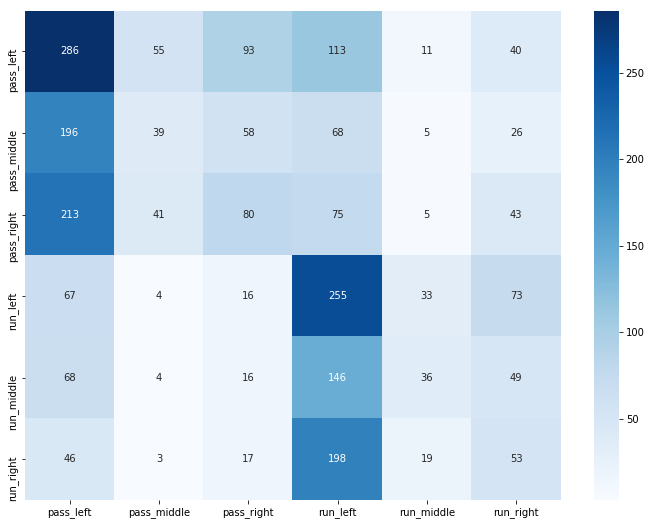

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, pred)

df_cm = pd.DataFrame(cm, index = [i for i in list(le.classes_)],
                  columns = [i for i in list(le.classes_)])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
